## Evidence analysis

The data used to simulate the QPO lightcurves.

|Parameter      |    $K_{rn}$ values   |    $K_{qpo + rn}$ values   |
|:--------------|:--------------------:|:--------------------------:|
|$a_{rn}$       |  exp(1)              |  exp(1)                    |
|$c_{rn}$       |  exp(1) $s^{-1}$     |  exp(1) $s^{-1}$           |
|$a_{qpo}$      |      -               |  exp(-2) or exp(-0.4)      |
|$c_{qpo}$      |      -               |  exp(1) $s^{-1}$           |
|$f_{qpo}$      |      -               |      20 Hz                 |
|A              |      3               |      3                     |
|$t_{0}$        |      0.5 s           |      0.5 s                 |
|$\sigma$       |      0.2 s           |      0.2 s                 |

We will simulate lightcurves and anlyse the evidences produced

In [106]:
# Dependancies

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess, kernels
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

import functools

In [200]:
# Mean Model

def gaussian(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

# Build Gp
def build_gp(kernel_params, mean_params, t, kernel_type, mean_type = "gaussian"):
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5) + kernels.quasisep.Celerite(
                a = kernel_params["aqpo"], b = 0.0, c = kernel_params["cqpo"], d = kernel_params["freq"])
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5)
    
    # Using partial to make the mean so that it only takes the time value
    if mean_type == "gaussian":
        mean = functools.partial(gaussian, mean_params = mean_params)
        return tinygp.GaussianProcess( kernel, t, mean=mean)
    elif mean_type == "constant":
        mean = mean_params
        return tinygp.GaussianProcess( kernel, t)

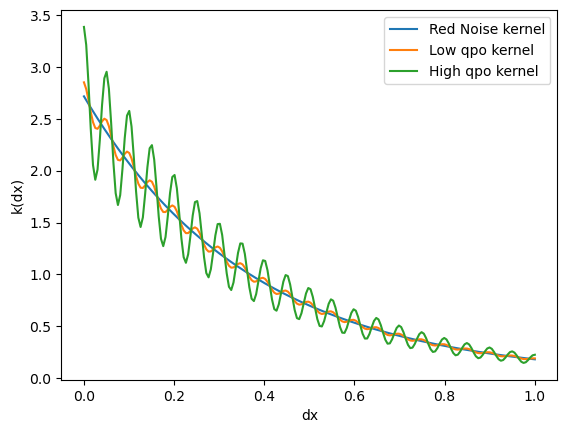

In [151]:
def plot_kernel(kernel, **kwargs):
    """ A function to plot the kernel"""
    dx = np.linspace(0, 1, 200)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    # print(kernel(dx, dx[:1]))
    plt.xlabel("dx")
    plt.legend()
    plt.ylabel("k(dx)")

rnparams = {
    "arn": jnp.exp(1.0),    "crn": jnp.exp(1.0),
    # "arn": jnp.exp(-1.0),    "crn": jnp.exp(1.0),
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}

rnkernel = kernels.quasisep.Exp(
                scale = 1/rnparams["crn"], sigma = (rnparams["arn"])**0.5)

lqpoparams = {
    "arn" : jnp.exp(1.0),   "crn" : jnp.exp(1.0),
    # "arn" : jnp.exp(-1.0),   "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),   "cqpo": jnp.exp(1),    "freq": 2*jnp.pi*20
}

lqpokernel = kernels.quasisep.Exp(
    scale = 1/lqpoparams["crn"], sigma = (lqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = lqpoparams["aqpo"], b = 0.0, c = lqpoparams["cqpo"], d = lqpoparams["freq"])

hqpoparams = {
    "arn" : jnp.exp(1.0),    "crn" : jnp.exp(1.0),
    # "arn" : jnp.exp(-1.0),    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 2*jnp.pi*20,
    # This is incorrect, the frequency is showing lower than it should be
}

hqpokernel = kernels.quasisep.Exp(
    scale = 1/hqpoparams["crn"], sigma = (hqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = hqpoparams["aqpo"], b = 0.0, c = hqpoparams["cqpo"], d = hqpoparams["freq"])

plot_kernel(rnkernel, label="Red Noise kernel")
plot_kernel(lqpokernel, label="Low qpo kernel")
plot_kernel(hqpokernel, label="High qpo kernel")

Text(0, 0.5, 'M(x)')

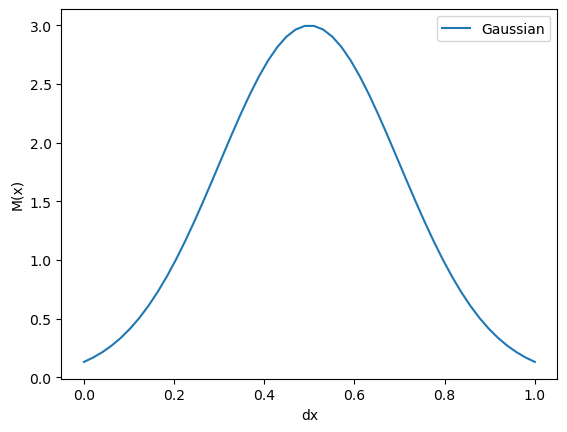

In [152]:
# Plotting the mean function:-
mean_params = {
    "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
}

gaussian2 = functools.partial(gaussian, mean_params = mean_params)

dx = np.linspace(0, 1, 50)
plt.plot(dx, gaussian2(dx), label = "Gaussian")
plt.xlabel("dx")
plt.legend()
plt.ylabel("M(x)")

In [153]:
# MAKING THE SIMULATION

Times = np.linspace(0,1,256)  # 1 secound lightcurve with 256 points

rngp = build_gp(rnparams, mean_params, Times, kernel_type = "RN")
lqpogp = build_gp(lqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")
hqpogp = build_gp(hqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")

Text(0.5, 0, 'x')

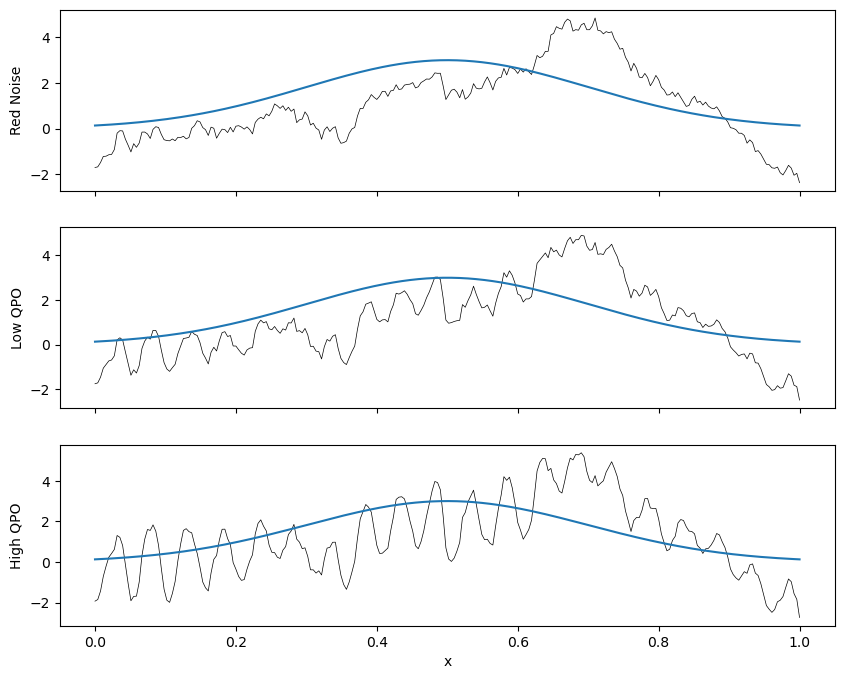

In [156]:
# Taking samples and plotting them
n = 1
rngp_sample = rngp.sample(jax.random.PRNGKey(4), shape=(n,))
lqpogp_sample = lqpogp.sample(jax.random.PRNGKey(4), shape=(n,))
hqpogp_sample = hqpogp.sample(jax.random.PRNGKey(4), shape=(n,))

# Plotting these samples
_, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
ax = axes[0]
ax.plot(Times, rngp_sample.T, color="k", lw=0.5)
# ax.scatter(Times, rngp_sample.T, s = 1)
ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("Red Noise")

ax = axes[1]
ax.plot(Times, lqpogp_sample.T, color="k", lw=0.5)
# ax.scatter(Times, lqpogp_sample.T, s = 1)
ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("Low QPO")

ax = axes[2]
ax.plot(Times, hqpogp_sample.T, color="k", lw=0.5)
# ax.scatter(Times, hqpogp_sample.T, s =1)
ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("High QPO")

ax.set_xlabel("x")

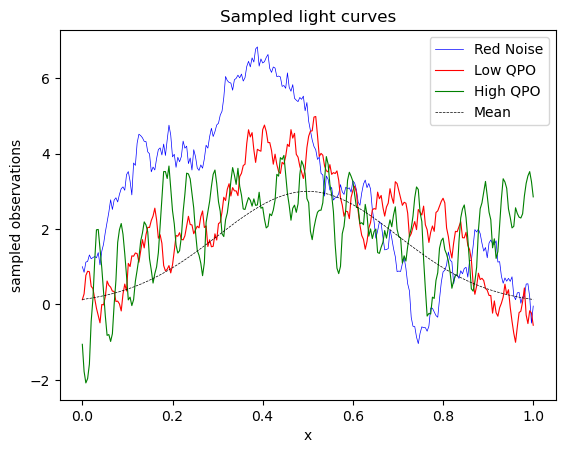

In [158]:
rngp_sample2   =  rngp.sample( jax.random.PRNGKey(1), shape=(1,))
lqpogp_sample2 = lqpogp.sample(jax.random.PRNGKey(2), shape=(1,))
hqpogp_sample2 = hqpogp.sample(jax.random.PRNGKey(3), shape=(1,))

plt.plot(Times, rngp_sample2.T, lw=0.5,color = "b" ,label = "Red Noise")
plt.plot(Times, lqpogp_sample2.T, lw=0.8, color = "r", label = "Low QPO")
plt.plot(Times, hqpogp_sample2.T, lw=0.8, color = "g", label = "High QPO")
plt.plot(Times, gaussian2(Times), color = "k", lw=0.5, ls = "--", label = "Mean")
plt.xlabel("x")
plt.ylabel("sampled observations")
plt.legend()
_ = plt.title("Sampled light curves")

# this evidence is correct as this lightcurve does not look like a qpo lightcurve
# Make an entirely different kernel lightcurve and see the difference

Finding evidences and taking samples to see results of bayesian inference on these lightcurve [Detailed analysis]

In [159]:
# Calculating evidences using jaxns
# Loading dependencies

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence
from jaxns import Prior, Model

tfpd = tfp.distributions

In [178]:
def RNprior_model():
    # TBD1: Is it log Normal or Uniform?
    # TBD2: Feeding the values manually, should be put for lightcurve to lightcurve
    arn = yield Prior(tfpd.Uniform(0.0, 20.0), name='arn') # log uniform
    crn = yield Prior(tfpd.Uniform(1., 256/2), name='crn')
    A = yield Prior(tfpd.Uniform(0.05*20, 2*20), name='A') # log uniform
    t0 = yield Prior(tfpd.Uniform(0.0, 1.0), name='t0')
    sig = yield Prior(tfpd.Uniform(0.0, 1.0), name='sig')
    return arn, crn, A, t0, sig


def QPOprior_model():
    arn = yield Prior(tfpd.Uniform(0.0, 20.0), name='arn')
    crn = yield Prior(tfpd.Uniform(1., 256/2), name='crn')
    # Should be Based on the lightcurve
    aqpo = yield Prior(tfpd.Uniform(0.0, 20.0), name='aqpo')
    # Should be dependent on the freq below (max value less than freq), Hense adjusting for that
    cqpo = yield Prior(tfpd.Uniform(0.1*1, 256/8), name='cqpo')
    freq = yield Prior(tfpd.Uniform(jnp.log(1.), 2*jnp.pi*256/2 ), name='freq')

    A = yield Prior(tfpd.Uniform(0.05*20, 2*20), name='A')
    t0 = yield Prior(tfpd.Uniform(0.0, 1.0), name='t0')
    sig = yield Prior(tfpd.Uniform(0.0, 1.0), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig

hqpogp_sample3 = hqpogp.sample(jax.random.PRNGKey(4))
print(type(hqpogp_sample3))
print(hqpogp_sample3.shape)
print(hqpogp.log_probability(hqpogp_sample3))

<class 'jaxlib.xla_extension.ArrayImpl'>
(256,)
-49.170738118565595


In [179]:
def RNlog_likelihood(arn, crn, A, t0, sig):
    rnlikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": 0.0,
        "cqpo": 0.0,
        "freq": 0.0,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    gp = build_gp(rnlikelihood_params, mean_params, Times, kernel_type = "RN")
    return gp.log_probability(hqpogp_sample3)

def QPOlog_likelihood(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
    qpolikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": aqpo,
        "cqpo": cqpo,
        "freq": freq,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    gp = build_gp(qpolikelihood_params, mean_params, Times, kernel_type = "QPO_plus_RN")
    # Condition on the data
    return gp.log_probability(hqpogp_sample3)

RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood)
RNmodel.sanity_check(random.PRNGKey(10), S = 100)

INFO[2023-06-05 21:17:15,355]: Sanity check...
INFO[2023-06-05 21:17:15,358]: Sanity check passed


In [180]:
RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500,
                             max_samples= 1e4)

RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)
print(RNresults.log_Z_mean)

-197.48551074889977


In [181]:
RNexact_ns.summary(RNresults)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1051086
# samples: 9152
# slices: 270000.0
# slices / acceptance: 36.0
# likelihood evals / sample: 114.8
# likelihood evals / slice: 3.9
--------
logZ=-197.49 +- 0.12
H=200.0
ESS=1543
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.2 +- 1.8 | 1.3 / 2.7 / 5.7 | 3.5 | 3.5
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 8.2 +- 4.7 | 2.8 / 7.4 / 15.9 | 3.5 | 3.5
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 6.1 +- 4.3 | 2.1 / 4.5 / 12.3 | 9.2 | 9.2
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 0.36 +- 0.25 | 0.1 / 0.29 / 0.8 | 0.01 | 0.01
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.57 +- 0.21 | 0.28 / 0.61 / 0.87 | 0.39 | 0.39
--------


WARNING[2023-06-05 21:18:20,286]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


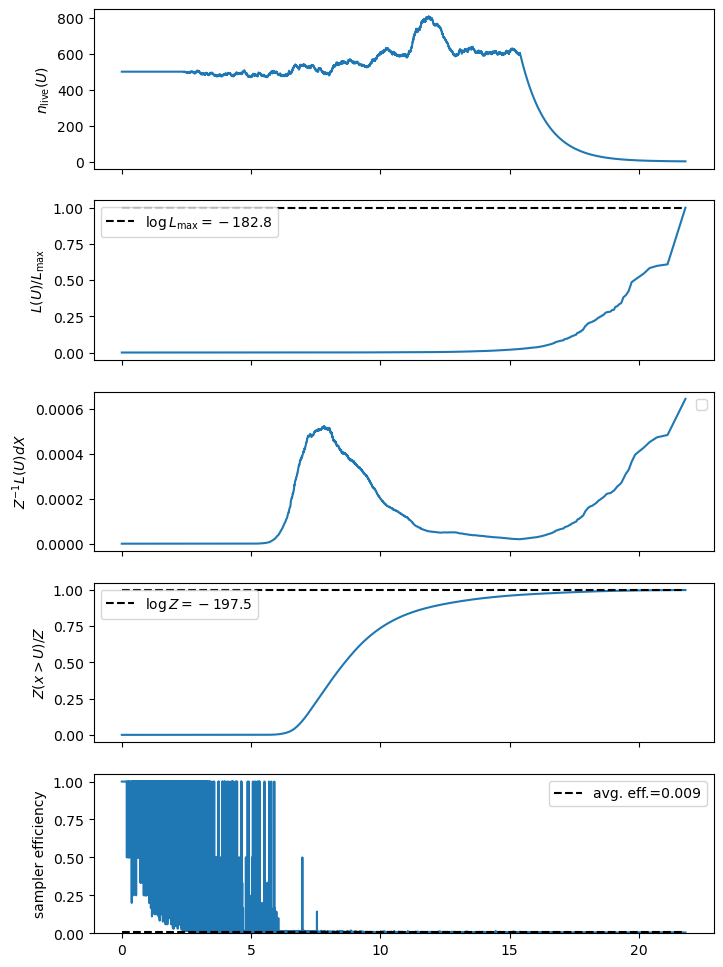

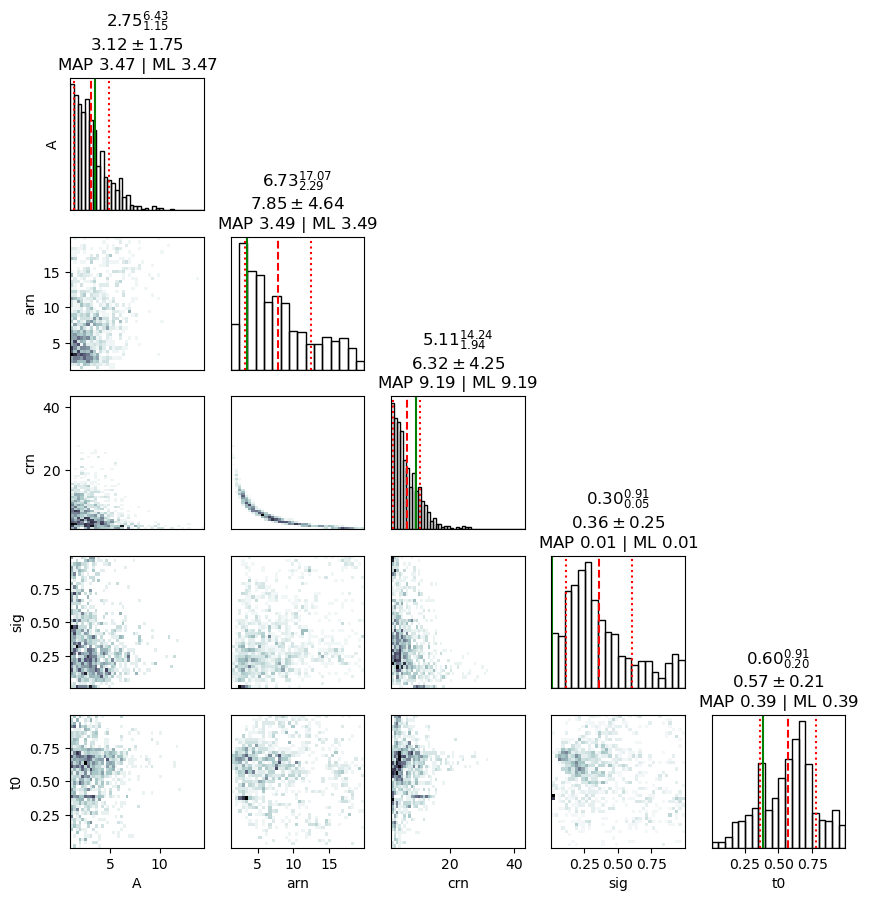

In [182]:
RNexact_ns.plot_diagnostics(RNresults)
RNexact_ns.plot_cornerplot(RNresults)

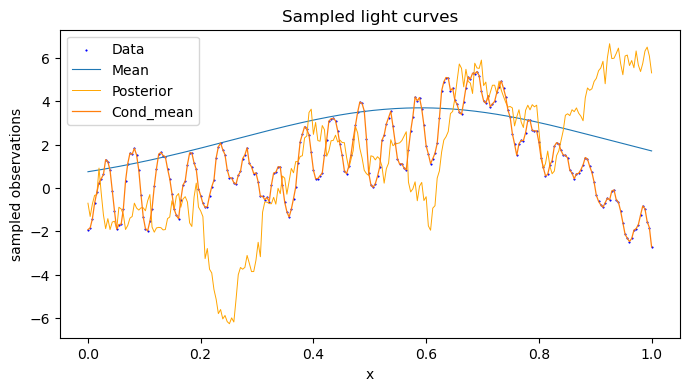

In [183]:
# Plot the lightcurve and the expected model conditioned on the data
# Problem, getting the mean or the max prior value after sampling

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.plot(Times, hqpogp_sample3.T, lw=0.5, color = "b", label = "Data")
ax.scatter(Times, hqpogp_sample3.T, lw=0.5, color = "b", label = "Data", s = 1)

post_rnparams = {
    "arn": 7.2,    "crn": 7.5,
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}
post_rnmeanparams = {
    "A": 3.7,    "t0": 0.59,    "sig": 0.33
}

gp = build_gp(post_rnparams, post_rnmeanparams, Times, kernel_type = "RN")
_ , cond_gp = gp.condition(hqpogp_sample3)
ax.plot(Times, gp.mean, lw=0.8, label = "Mean") 
ax.plot(Times, gp.sample(jax.random.PRNGKey(10), shape=(1,)).T, lw=0.7, c = "orange", label = "Posterior")
ax.plot(Times, cond_gp.mean, lw = 0.9, label = "Cond_mean")
# ax.plot(Times, RNresults.posterior_samples["mean"].T, lw=0.8, color = "r", label = "Mean")
ax.set_xlabel("x")
ax.set_ylabel("sampled observations")
ax.legend()
_ = plt.title("Sampled light curves")


In [184]:
QPOmodel = Model(prior_model= QPOprior_model, log_likelihood=QPOlog_likelihood)
QPOmodel.sanity_check(random.PRNGKey(10), S = 100)

QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500,
                             max_samples= 1e4)

QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)

print(QPOresults.log_Z_mean)

INFO[2023-06-05 21:21:04,411]: Sanity check...
INFO[2023-06-05 21:21:04,414]: Sanity check passed


-66.73788132976297


In [185]:
QPOexact_ns.summary(QPOresults)

--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 1382560
# samples: 10000
# slices: 542620.0
# slices / acceptance: 65.0
# likelihood evals / sample: 138.3
# likelihood evals / slice: 2.5
--------
logZ=-66.74 +- 0.19
H=67.0
ESS=785
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 1.89 +- 0.76 | 1.13 / 1.7 / 2.91 | 1.85 | 1.85
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.93 +- 0.88 | 0.58 / 2.18 / 2.9 | 0.89 | 0.89
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 4.3 +- 1.2 | 2.9 / 4.2 / 6.0 | 4.2 | 4.2
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 0.59 +- 0.59 | 0.16 / 0.35 / 1.4 | 0.53 | 0.53
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 2.1 +- 0.75 | 1.33 / 1.96 / 2.95 | 1.99 | 1.99
--------
freq: mean +- std.dev. | 10%ile 

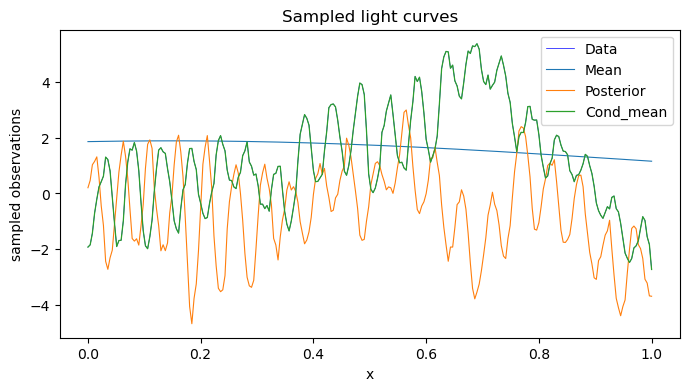

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(Times, hqpogp_sample3.T, lw=0.5, color = "b", label = "Data")
post_qpoparams = {
    "arn": 4.3,    "crn": 2.1,
    "aqpo": 1.93,    "cqpo": 0.59,    "freq": 124.4
}
post_qpomeanparams = {
    "A": 1.89,    "t0": 0.149,    "sig": 0.86
}

gp = build_gp(post_qpoparams, post_qpomeanparams, Times, kernel_type = "QPO_plus_RN")
_ , cond_gp = gp.condition(hqpogp_sample3)
ax.plot(Times, gp.mean, lw=0.8, label = "Mean") 
ax.plot(Times, gp.sample(jax.random.PRNGKey(7)), lw=0.8, label = "Posterior")
# When we are using the same key, then very similar samples are drawn
ax.plot(Times, cond_gp.mean, lw = 0.9, label = "Cond_mean")
# ax.plot(Times, RNresults.posterior_samples["mean"].T, lw=0.8, color = "r", label = "Mean")
ax.set_xlabel("x")
ax.set_ylabel("sampled observations")
ax.legend()
_ = plt.title("Sampled light curves")

WARNING[2023-06-05 21:28:56,546]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


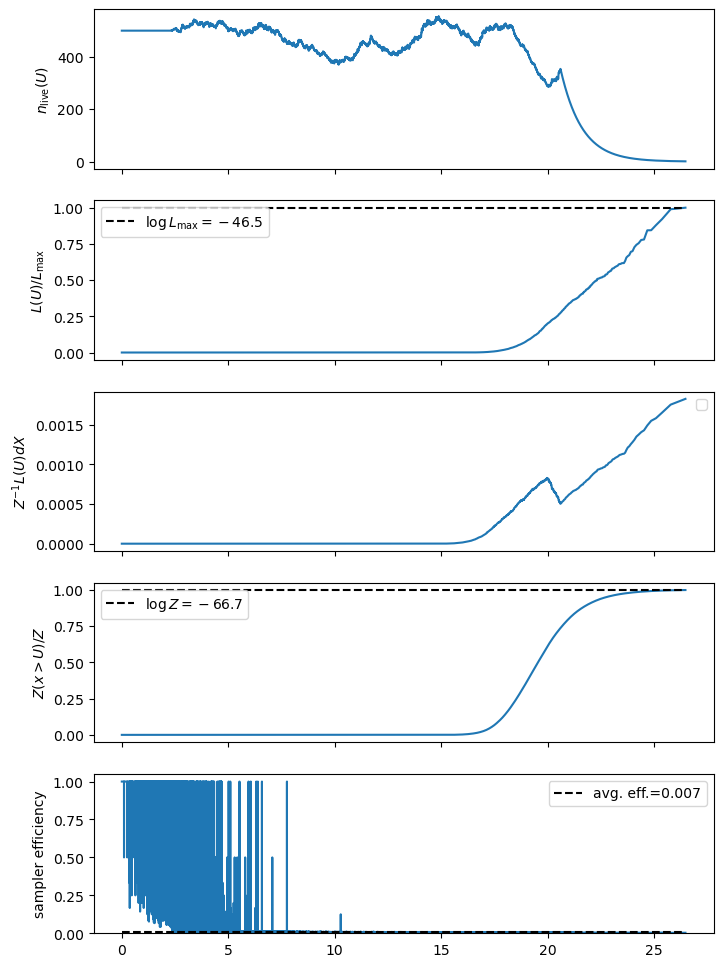

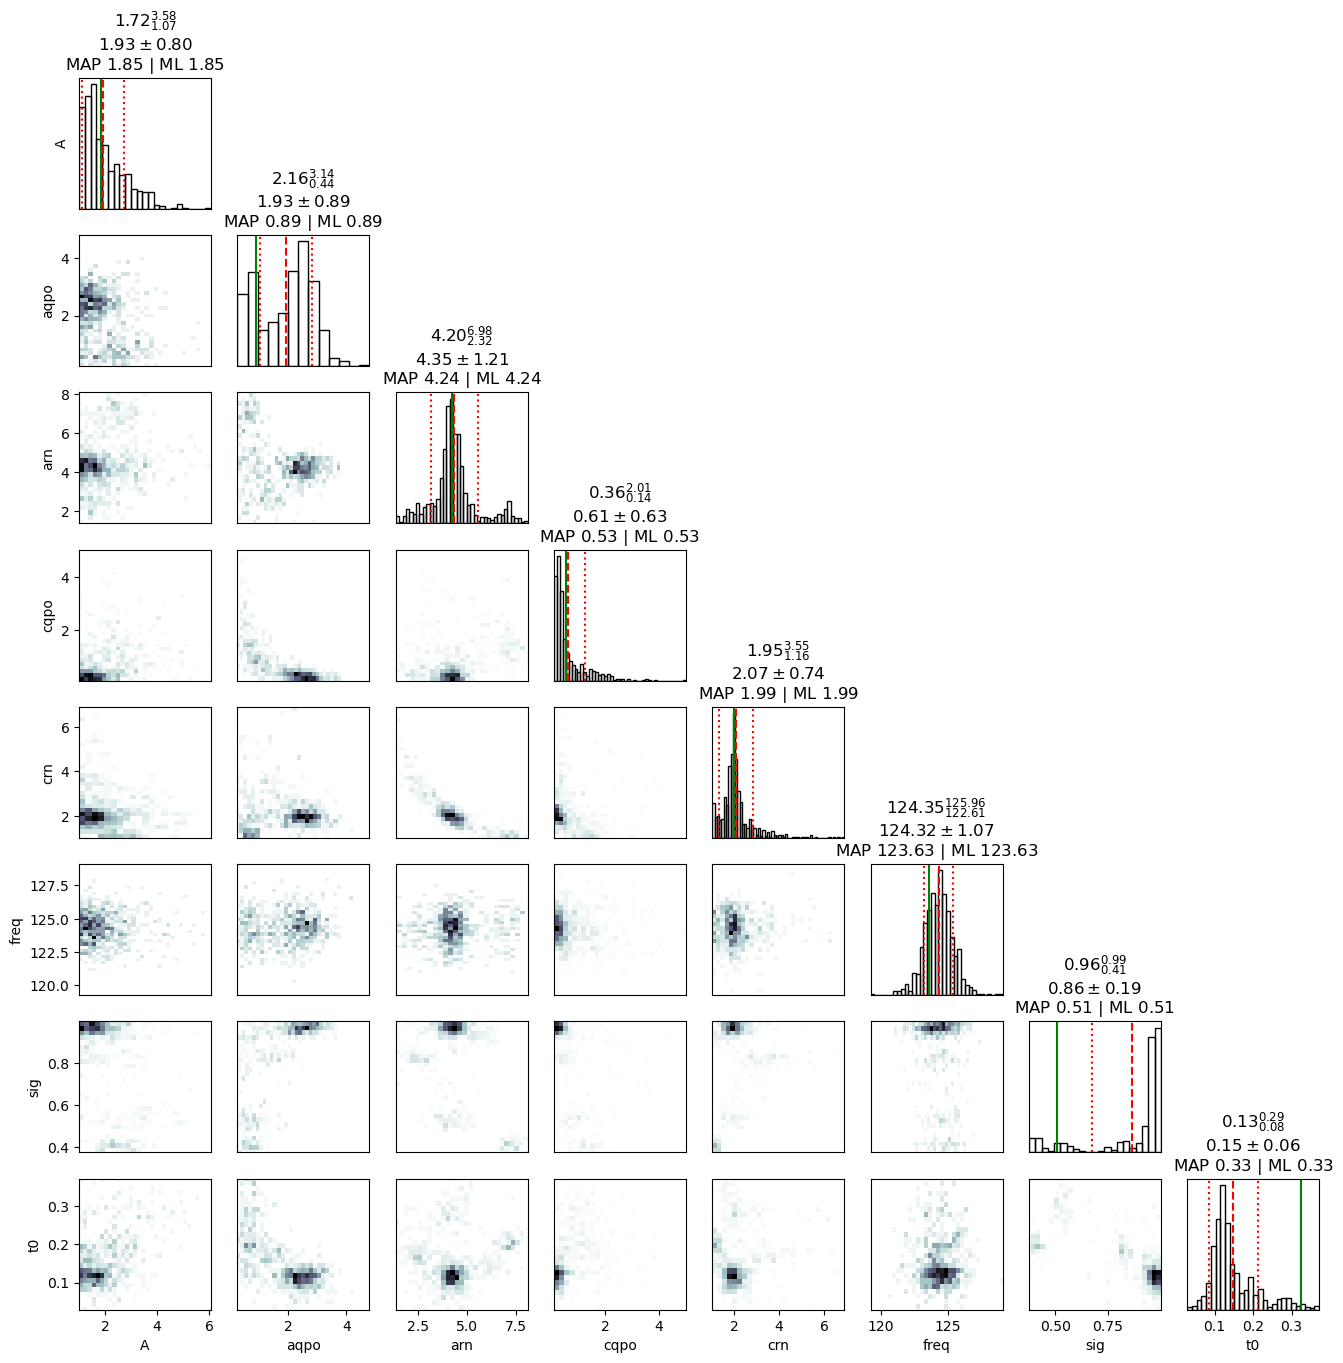

In [190]:
QPOexact_ns.plot_diagnostics(QPOresults)
QPOexact_ns.plot_cornerplot(QPOresults)

Making fig 6 from morris paper

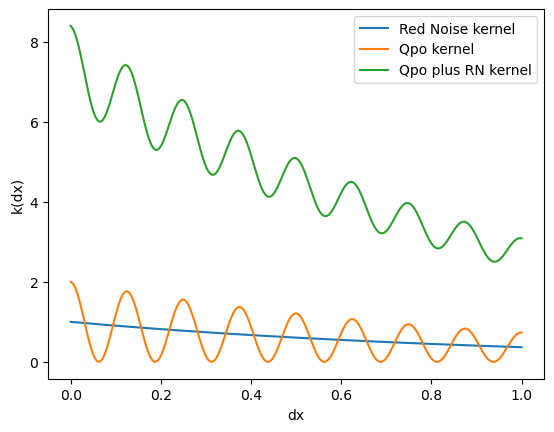

In [191]:
M_rnparams = {
    "arn": 1.0,    "crn": 1.0,
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}

M_rnkernel = kernels.quasisep.Exp(
                scale = 1/M_rnparams["crn"], sigma = (M_rnparams["arn"])**0.5)

M_qpoparams = {
    "arn" : 1.0,   "crn" : 1.0,
    "aqpo": 1.0,   "cqpo": 1.0,    "freq": 2*jnp.pi*8
}

M_qpokernel = kernels.quasisep.Exp(
    scale = 1/M_qpoparams["crn"], sigma = (M_qpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = M_qpoparams["aqpo"], b = 0.0, c = M_qpoparams["cqpo"], d = M_qpoparams["freq"])

M_qpo_plus_rn_params = {
    "arn" : jnp.exp(2.0),    "crn" : 1.0,
    "aqpo": 1.0,   "cqpo": 1.0,    "freq": 2*jnp.pi*8,
}

M_qpo_plus_rn_kernel = kernels.quasisep.Exp(
    scale = 1/M_qpo_plus_rn_params["crn"], sigma = (M_qpo_plus_rn_params["arn"])**0.5) + kernels.quasisep.Celerite(
        a = M_qpo_plus_rn_params["aqpo"], b = 0.0, c = M_qpo_plus_rn_params["cqpo"], d = M_qpo_plus_rn_params["freq"])

plot_kernel(M_rnkernel, label="Red Noise kernel")
plot_kernel(M_qpokernel, label="Qpo kernel")
plot_kernel(M_qpo_plus_rn_kernel, label="Qpo plus RN kernel")

Text(0.5, 0, 'x')

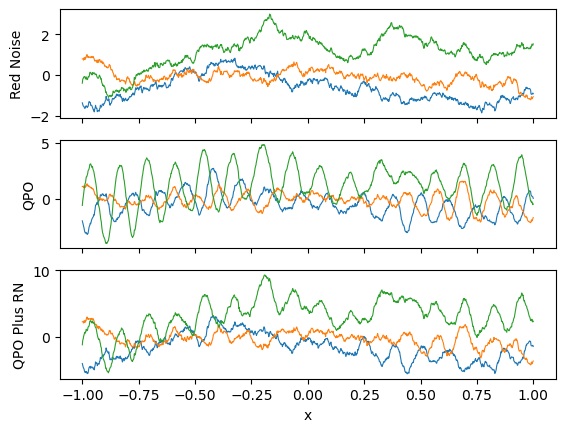

In [203]:
# MAKING THE SIMULATION

Times2 = np.linspace(-1,1,512*2)  # 1 secound lightcurve with 256 points

M_rn_gp = build_gp(M_rnparams, 0, Times2, kernel_type = "RN", mean_type = "constant")
M_qpo_gp = build_gp(M_qpoparams, 0, Times2, kernel_type = "QPO_plus_RN", mean_type = "constant")
M_qpo_plus_rn_gp = build_gp(M_qpo_plus_rn_params, 0, Times2, kernel_type = "QPO_plus_RN", mean_type = "constant")

# Taking samples and plotting them
M_rngp_sample = M_rn_gp.sample(jax.random.PRNGKey(4), shape=(3,))
M_qpogp_sample = M_qpo_gp .sample(jax.random.PRNGKey(4), shape=(3,))
M_qpo_plus_rn_qpogp_sample = M_qpo_plus_rn_gp.sample(jax.random.PRNGKey(4), shape=(3,))

# Plotting these samples
_, axes = plt.subplots(3, 1, sharex=True)
ax = axes[0]
ax.plot(Times2, M_rngp_sample.T, lw=0.8)
# ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("Red Noise")

ax = axes[1]
ax.plot(Times2, M_qpogp_sample.T, lw=0.8)
# ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("QPO")

ax = axes[2]
ax.plot(Times2, M_qpo_plus_rn_qpogp_sample.T, lw=0.8)
# ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("QPO Plus RN")

ax.set_xlabel("x")

The text for the image is as follows:-
Realisations of GPs with a red noise krn (top left), quasi-periodic kqpo (middle left), and combined red noise and quasi-periodic kqpo+rn kernels (bottom left). The figures on the right are the corresponding power spectra to the time series on the left. We set aqpo = arn = cqpo = crn = 1 and fqpo = 8 in the first and second panel, and use the same parameters except for arn = exp(2) in the third panel

![Simulated Lightcurve](./Images/Simulated_lightcurves.png)